# A generational model of support for gun control

Allen Downey

[MIT License](https://en.wikipedia.org/wiki/MIT_License)

In [36]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

import pandas as pd
import numpy as np

import thinkstats2
import thinkplot
import utils

import matplotlib.pyplot as plt
import matplotlib

import seaborn as sns
sns.set(style='white', font_scale=1.0, context='talk')
RED, BLUE, GREEN, PURPLE, ORANGE, YELLOW = sns.color_palette('Set1')

from collections import Counter

import statsmodels.formula.api as smf
from statsmodels.discrete.discrete_model import MNLogit
from statsmodels.discrete.discrete_model import Logit

## Loading and validation

Reading data from the [General Social Survey](https://gssdataexplorer.norc.org/projects/29853)

You can get my selected subset of variables from 
https://gssdataexplorer.norc.org/projects/48515

In [2]:
gss = utils.ReadGss('gss_gun')
print(gss.shape)
gss.head()

(62466, 24)


,year,conrinc,cohort,ballot,wtssall,income,finrela,realinc,sex,homosex,...,age,race,srcbelt,polviews,natcrime,gunlaw,gun,gunage,gunnum,educ
0,1972,0.0,1949,0,0.4446,0,3,18951.0,2,0,...,23,1,3,0,0,1,0,0,0,16
1,1972,0.0,1902,0,0.8893,0,4,24366.0,1,0,...,70,1,3,0,0,1,0,0,0,10
2,1972,0.0,1924,0,0.8893,0,3,24366.0,2,0,...,48,1,3,0,0,1,0,0,0,12
3,1972,0.0,1945,0,0.8893,0,3,30458.0,2,0,...,27,1,3,0,0,1,0,0,0,17
4,1972,0.0,1911,0,0.8893,0,4,50763.0,2,0,...,61,1,3,0,0,1,0,0,0,12


In [3]:
def replace_invalid(df):
    df.gunlaw.replace([8, 9, 0], np.nan, inplace=True)
    df.owngun.replace([3, 8, 9, 0], np.nan, inplace=True)
    df.gun.replace([8, 9, 0], np.nan, inplace=True)
    df.natcrime.replace([8, 9, 0], np.nan, inplace=True)
    df.income.replace([0, 13, 98, 99], np.nan, inplace=True)
    df.realinc.replace([0], np.nan, inplace=True)                  # TODO: check this
    df.educ.replace([98,99], np.nan, inplace=True)
    df.polviews.replace([8, 9, 0], np.nan, inplace=True)
    df.age.replace([98, 99], np.nan, inplace=True)               # 89 means 89 or older
    df.hispanic.replace([98, 99, 0], np.nan, inplace=True)
    df.cohort.replace([9999], np.nan, inplace=True)

In [5]:
replace_invalid(gss)

In [4]:
def numnull(series):
    return sum(series.isnull())

### Variable `gunlaw`

Would you favor or oppose a law which would require a person to obtain a police permit before he or she could buy a gun?

https://gssdataexplorer.norc.org/projects/41723/variables/272/vshow

In [6]:
numnull(gss.gunlaw)

21994

In [7]:
utils.values(gss, 'gunlaw')

1.0    30936
2.0     9536
Name: gunlaw, dtype: int64

### Variable `owngun`

Do you happen to have in your home (IF HOUSE: or garage) any guns or revolvers?

https://gssdataexplorer.norc.org/projects/41723/variables/679/vshow

In [8]:
numnull(gss.owngun)

24826

In [9]:
utils.values(gss, 'owngun')

1.0    15122
2.0    22518
Name: owngun, dtype: int64

### Variable `gun`

Have you ever been threatened with a gun, or shot at? 

https://gssdataexplorer.norc.org/projects/41723/variables/661/vshow

In [10]:
numnull(gss.gun)

43138

In [11]:
utils.values(gss, 'gun')

1.0     3775
2.0    15553
Name: gun, dtype: int64

### Variable `natcrime`

We are faced with many problems in this country, none of which can be solved easily or inexpensively. I'm going to name some of these problems, and for each one I'd like you to name some of these problems, and for each one I'd like you to tell me whether you think we're spending too much money on it, too little money, or about the right amount. First (READ ITEM A) . . . are we spending too much, too little, or about the right amount on (ITEM)? 
E. Halting the rising crime rate

[Note: the wording of this question assumes that crime rates are rising!]

https://gssdataexplorer.norc.org/projects/41723/variables/185/vshow

In [12]:
numnull(gss.natcrime)

28064

In [13]:
utils.values(gss, 'natcrime')

1.0    23200
2.0     9099
3.0     2103
Name: natcrime, dtype: int64

### Variable `income`

In which of these groups did your total family income, from all sources, fall last year before taxes, that is?



In [14]:
varname = 'income'
numnull(gss[varname])

7961

In [15]:
utils.values(gss, varname)

1.0       762
2.0      1301
3.0      1253
4.0      1153
5.0      1267
6.0      1214
7.0      1268
8.0      2149
9.0      6354
10.0     4965
11.0     5047
12.0    27772
Name: income, dtype: int64

In [16]:
gss[varname].describe()

count    54505.000000
mean        10.036492
std          2.845831
min          1.000000
25%          9.000000
50%         12.000000
75%         12.000000
max         12.000000
Name: income, dtype: float64

### Variable `realinc`

Family income on 1972-2006 surveys in constant dollars (base = 1986)

https://gssdataexplorer.norc.org/variables/5198/vshow


In [17]:
varname = 'realinc'
numnull(gss[varname])

6325

In [18]:
gss[varname].describe()

count     56141.000000
mean      31636.199666
std       29402.370825
min         234.000000
25%       12080.625000
50%       24097.500000
75%       39022.500000
max      162607.000000
Name: realinc, dtype: float64

### Variable `educ`

A. What is the highest grade in elementary school or high school that (you/your father/ your mother/your [husband/wife]) finished and got credit for? CODE EXACT GRADE. 
B. IF FINISHED 9th-12th GRADE OR DK*: Did (you/he/she) ever get a high school diploma or a GED certificate? [SEE D BELOW.] [See REMARKS] 
C. Did (you/he/she) complete one or more years of college for credit--not including schooling such as business college, technical or vocational school? IF YES: How many years did (you/he/she) complete? 
Do you (Does [he/she]) have any college degrees? (IF YES: What degree or degrees?) CODE HIGHEST DEGREE EARNED.

https://gssdataexplorer.norc.org/projects/41723/variables/55/vshow


In [19]:
varname = 'educ'
numnull(gss[varname])

174

In [20]:
utils.values(gss, varname)

0.0       161
1.0        45
2.0       148
3.0       247
4.0       314
5.0       399
6.0       808
7.0       871
8.0      2689
9.0      2032
10.0     2815
11.0     3648
12.0    19006
13.0     5177
14.0     6847
15.0     2783
16.0     7925
17.0     1870
18.0     2265
19.0      875
20.0     1367
Name: educ, dtype: int64

### Variable `polviews`


A. We hear a lot of talk these days about liberals and conservatives. 
I'm going to show you a seven-point scale on which the political views that people might hold are arranged from extremely liberal--point 1--to extremely conservative--point 7. Where would you place yourself on this scale?

https://gssdataexplorer.norc.org/projects/41723/variables/178/vshow

In [21]:
varname = 'polviews'
numnull(gss[varname])

9385

In [22]:
utils.values(gss, varname)

1.0     1560
2.0     6236
3.0     6754
4.0    20515
5.0     8407
6.0     7876
7.0     1733
Name: polviews, dtype: int64

### Age 

https://gssdataexplorer.norc.org/projects/29853/variables/53/vshow

In [23]:
numnull(gss.age)

221

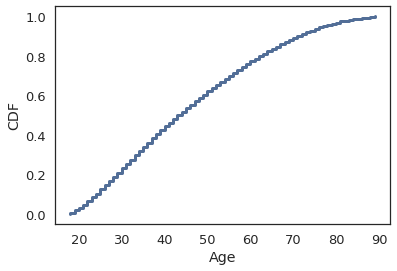

In [24]:
thinkplot.Cdf(thinkstats2.Cdf(gss.age))
thinkplot.Config(xlabel='Age', ylabel='CDF')

### Year of birth 

https://gssdataexplorer.norc.org/projects/29853/variables/5507/vshow

In [25]:
numnull(gss.cohort)

221

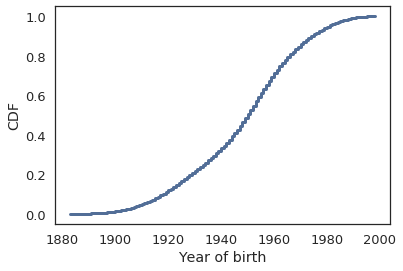

In [26]:
thinkplot.Cdf(thinkstats2.Cdf(gss.cohort))
thinkplot.Config(xlabel='Year of birth', ylabel='CDF')

### Sex 

https://gssdataexplorer.norc.org/projects/41723/variables/81/vshow

In [27]:
numnull(gss.sex)

0

In [28]:
utils.values(gss, 'sex')

1    27562
2    34904
Name: sex, dtype: int64

### Race

https://gssdataexplorer.norc.org/projects/41723/variables/82/vshow

CODE WITHOUT ASKING ONLY IF THERE IS NO DOUBT IN YOUR MIND. 
What race do you consider yourself? RECORD VERBATIM AND CODE.

In [29]:
numnull(gss.race)

0

In [30]:
utils.values(gss, 'race')

1    50340
2     8802
3     3324
Name: race, dtype: int64

### Hispanic 



In [31]:
numnull(gss.hispanic)

38149

In [32]:
utils.values(gss, 'hispanic')

1.0     21571
2.0      1661
3.0       346
4.0       115
5.0        91
6.0        52
7.0        14
8.0        18
9.0         3
10.0       25
11.0       38
15.0       63
16.0        1
20.0       27
21.0       32
22.0       37
23.0       13
24.0       12
25.0        3
30.0      121
31.0        2
35.0        7
40.0        5
41.0       21
42.0        1
45.0        3
46.0       12
47.0       13
50.0       10
Name: hispanic, dtype: int64

### srcbelt

C. SRC (SURVEY RESEARCH CENTER, UNIVERSITY OF MICHIGAN) NEW BELT CODE

https://gssdataexplorer.norc.org/projects/41723/variables/121/vshow

In [33]:
numnull(gss.srcbelt)

0

In [34]:
utils.values(gss, 'srcbelt')

1     5572
2     8670
3     7113
4     9348
5    23583
6     8180
Name: srcbelt, dtype: int64

### Make age and cohort groups

Group people into 5- and 10-year bins by birth year.

In [35]:
gss['cohort5'] = utils.RoundIntoBins(gss, 'cohort', 5, low=2) + 2.5

In [37]:
grouped_cohort = gss.groupby(['cohort5'])

# count cases where we have the dependent var
counts = grouped_cohort.gunlaw.count()

cohort5
1884.5      15
1889.5      85
1894.5     216
1899.5     443
1904.5     722
1909.5    1089
1914.5    1500
1919.5    1837
1924.5    2145
1929.5    2146
1934.5    2328
1939.5    2616
1944.5    3336
1949.5    4254
1954.5    4150
1959.5    3717
1964.5    2935
1969.5    2230
1974.5    1644
1979.5    1266
1984.5     879
1989.5     560
1994.5     213
1999.5      14
2004.5     132
Name: gunlaw, dtype: int64

To avoid a final data point with a small sample size, I chose `low` to minimize the number of people in the last group, and I've lumped them in with the previous group.

In [38]:
gss.loc[gss.cohort5==1999.5, 'cohort5'] = 1994.5
gss.loc[gss.cohort5<1894, 'cohort5'] = 1894.5

In [39]:
grouped_cohort = gss.groupby(['cohort5'])
counts = grouped_cohort.gunlaw.count()

cohort5
1894.5     316
1899.5     443
1904.5     722
1909.5    1089
1914.5    1500
1919.5    1837
1924.5    2145
1929.5    2146
1934.5    2328
1939.5    2616
1944.5    3336
1949.5    4254
1954.5    4150
1959.5    3717
1964.5    2935
1969.5    2230
1974.5    1644
1979.5    1266
1984.5     879
1989.5     560
1994.5     227
2004.5     132
Name: gunlaw, dtype: int64

In [40]:
gss['cohort10'] = utils.RoundIntoBins(gss, 'cohort', 10)

In [41]:
grouped_cohort = gss.groupby(['cohort10'])
counts = grouped_cohort.gunlaw.count()
counts

cohort10
1880.0      53
1890.0     502
1900.0    1563
1910.0    3024
1920.0    4212
1930.0    4703
1940.0    6929
1950.0    8212
1960.0    5721
1970.0    3278
1980.0    1750
1990.0     393
2000.0     132
Name: gunlaw, dtype: int64

Here's the number of respondents in each year.

In [42]:
utils.values(gss, 'year')

1972    1613
1973    1504
1974    1484
1975    1490
1976    1499
1977    1530
1978    1532
1980    1468
1982    1860
1983    1599
1984    1473
1985    1534
1986    1470
1987    1819
1988    1481
1989    1537
1990    1372
1991    1517
1993    1606
1994    2992
1996    2904
1998    2832
2000    2817
2002    2765
2004    2812
2006    4510
2008    2023
2010    2044
2012    1974
2014    2538
2016    2867
Name: year, dtype: int64

Group into 4 year intervals, chosen to get 2014 and 2016 into the last bin.

In [43]:
gss['year4'] = utils.RoundIntoBins(gss, 'year', 4, low=1970) + 1
utils.values(gss, 'year4')

1971    3117
1975    6003
1979    3000
1983    6466
1987    6307
1991    4495
1995    5896
1999    5649
2003    5577
2007    6533
2011    4018
2015    5405
Name: year4, dtype: int64

Group people into 5 and 3-year age groups.

In [44]:
gss['age5'] = utils.RoundIntoBins(gss, 'age', 5) + 2.5
utils.values(gss, 'age5')

17.5    1054
22.5    5283
27.5    6663
32.5    6784
37.5    6475
42.5    5924
47.5    5375
52.5    5007
57.5    4530
62.5    4047
67.5    3612
72.5    2955
77.5    2207
82.5    1381
87.5     948
92.5     221
Name: age5, dtype: int64

In [45]:
gss['age3'] = utils.RoundIntoBins(gss, 'age', 3, low=0) + 1.5
utils.values(gss, 'age3')

19.5    1924
22.5    3238
25.5    3815
28.5    4023
31.5    4094
34.5    4033
37.5    3951
40.5    3609
43.5    3496
46.5    3217
49.5    3178
52.5    3019
55.5    2817
58.5    2681
61.5    2538
64.5    2289
67.5    2184
70.5    1913
73.5    1690
76.5    1418
79.5    1114
82.5     840
85.5     573
88.5     591
91.5     221
Name: age3, dtype: int64

### Make booleans

In [46]:
def copy_nan(df, varname, newvar):
    """Put a NaN into newvar in any place where varname is Nan.
    
    df: DataFrame
    varname: string old var name
    newvar: string new var name
    """
    df.loc[df[varname].isnull(), newvar] = np.nan

In [47]:
def make_boolean(df, varname, values, newvar):
    """Make a boolean variable.
    
    df: DataFrame
    varname: name of base variable
    values: sequence of values for varname
    newvar: name of new variable (recode)
    """
    #assert numnull(df[varname]) == 0
    df[newvar] = df[varname].isin(values)
    copy_nan(df, varname, newvar)

In [49]:
def make_booleans(df):
    df['cohort10'] = utils.RoundIntoBins(df, 'cohort', 10)
    make_boolean(df, 'cohort10', [1920], 'twenties')
    make_boolean(df, 'cohort10', [1930], 'thirties')
    make_boolean(df, 'cohort10', [1940], 'forties')
    make_boolean(df, 'cohort10', [1950], 'fifties')
    make_boolean(df, 'cohort10', [1960], 'sixties')
    make_boolean(df, 'cohort10', [1970], 'seventies')
    make_boolean(df, 'cohort10', [1980], 'eighties')
    make_boolean(df, 'cohort10', [1990], 'nineties')
    make_boolean(df, 'gunlaw', [1.0], 'favor')
    make_boolean(df, 'owngun', [1.0], 'gunhome')
    make_boolean(df, 'gun', [1.0], 'threatened')
    make_boolean(df, 'natcrime', [1.0], 'spendcrime')
    make_boolean(df, 'income', [12], 'topincome')
    make_boolean(df, 'income', [1,2,3,4,5,6,7,8], 'lowincome')
    make_boolean(df, 'polviews', [1,2,3], 'liberal')
    make_boolean(df, 'polviews', [4], 'moderate')
    make_boolean(df, 'polviews', [6,7,8], 'conservative')
    make_boolean(df, 'sex', [2], 'female')
    make_boolean(df, 'hispanic', [2], 'ishisp')
    make_boolean(df, 'race', [2], 'black')
    make_boolean(df, 'race', [3], 'otherrace')
    make_boolean(df, 'srcbelt', [1,2,5], 'urban')
    make_boolean(df, 'srcbelt', [3,4], 'suburban')
    make_boolean(df, 'srcbelt', [6], 'rural')

    df['college'] = df['educ'] >= 13 
    copy_nan(df, 'educ', 'college')
    
    quantile25 = df['realinc'].quantile(0.25)
    df['lowrealinc'] = df['realinc'] <= quantile25 
    copy_nan(df, 'realinc', 'lowrealinc')

    quantile75 = df['realinc'].quantile(0.75)
    df['highrealinc'] = df['realinc'] >= quantile75 
    copy_nan(df, 'realinc', 'highrealinc')

In [50]:
make_booleans(gss)

### Resample

Divide the sample up by year; resample within each year, using sampling weights; then concatenate the annual samples.

In [53]:
sample = utils.ResampleByYear(gss).copy()
sample.shape

(62466, 56)

In [54]:
utils.values(sample, 'twenties')

0.0    56655
1.0     5811
Name: twenties, dtype: int64

In [55]:
utils.values(sample, 'thirties')

0.0    55572
1.0     6894
Name: thirties, dtype: int64

In [56]:
utils.values(sample, 'forties')

0.0    52222
1.0    10244
Name: forties, dtype: int64

In [57]:
utils.values(sample, 'fifties')

0.0    49391
1.0    13075
Name: fifties, dtype: int64

In [58]:
utils.values(sample, 'sixties')

0.0    52585
1.0     9881
Name: sixties, dtype: int64

In [59]:
utils.values(sample, 'seventies')

0.0    56205
1.0     6261
Name: seventies, dtype: int64

In [60]:
utils.values(sample, 'eighties')

0.0    59151
1.0     3315
Name: eighties, dtype: int64

In [61]:
utils.values(sample, 'nineties')

0.0    61576
1.0      890
Name: nineties, dtype: int64

In [62]:
utils.values(sample, 'favor')

0.0     9534
1.0    30989
Name: favor, dtype: int64

In [63]:
utils.values(sample, 'gunhome')

0.0    21469
1.0    16151
Name: gunhome, dtype: int64

In [64]:
utils.values(sample, 'threatened')

0.0    15574
1.0     3841
Name: threatened, dtype: int64

In [65]:
utils.values(sample, 'spendcrime')

0.0    11150
1.0    23436
Name: spendcrime, dtype: int64

In [66]:
utils.values(sample, 'topincome')

0.0    24155
1.0    29776
Name: topincome, dtype: int64

In [67]:
utils.values(sample, 'lowincome')

0.0    45412
1.0     8519
Name: lowincome, dtype: int64

In [68]:
utils.values(sample, 'lowrealinc')

0.0    44093
1.0    11509
Name: lowrealinc, dtype: int64

In [69]:
utils.values(sample, 'highrealinc')

0.0    39124
1.0    16478
Name: highrealinc, dtype: int64

In [70]:
utils.values(sample, 'liberal')

0.0    38976
1.0    14220
Name: liberal, dtype: int64

In [71]:
utils.values(sample, 'moderate')

0.0    32421
1.0    20775
Name: moderate, dtype: int64

In [72]:
utils.values(sample, 'conservative')

0.0    43497
1.0     9699
Name: conservative, dtype: int64

In [73]:
utils.values(sample, 'female')

0.0    28437
1.0    34029
Name: female, dtype: int64

In [74]:
utils.values(sample, 'ishisp')

0.0    22433
1.0     1880
Name: ishisp, dtype: int64

In [75]:
utils.values(sample, 'black')

0.0    53969
1.0     8497
Name: black, dtype: int64

In [76]:
utils.values(sample, 'otherrace')

0.0    58741
1.0     3725
Name: otherrace, dtype: int64

In [77]:
utils.values(sample, 'urban')

0.0    25376
1.0    37090
Name: urban, dtype: int64

In [78]:
utils.values(sample, 'suburban')

0.0    45334
1.0    17132
Name: suburban, dtype: int64

In [79]:
utils.values(sample, 'rural')

0.0    54222
1.0     8244
Name: rural, dtype: int64

In [80]:
utils.values(sample, 'college')

0.0    33429
1.0    28864
Name: college, dtype: int64

### Look at trends

In [51]:
def plot_series(grouped, varname, **options):
    """Plot a series of percentages from each group.
    
    grouped: groupby object
    varname: string variable name
    options: passed to Plot
    """
    series = grouped[varname].mean() * 100
    thinkplot.plot(series.dropna(), **options, label=varname)
    thinkplot.config(xlabel='Year of survey', 
                     ylabel='Percent',
                     xlim=[1971, 2017])

Here's what generational replacement looks like.

In [81]:
grouped_year4 = sample.groupby('year4')

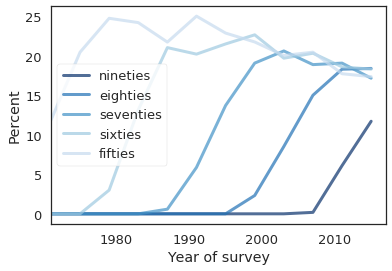

In [82]:
plot_series(grouped_year4, 'nineties')
plot_series(grouped_year4, 'eighties')
plot_series(grouped_year4, 'seventies')
plot_series(grouped_year4, 'sixties')
plot_series(grouped_year4, 'fifties')

Changes in proportions of various groups.

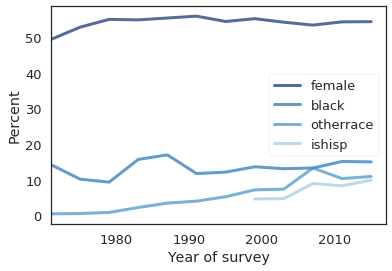

In [79]:
plot_series(grouped_year4, 'female')
plot_series(grouped_year4, 'black')
plot_series(grouped_year4, 'otherrace')
plot_series(grouped_year4, 'ishisp')

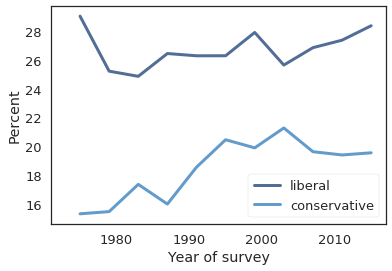

In [80]:
plot_series(grouped_year4, 'liberal')
plot_series(grouped_year4, 'conservative')

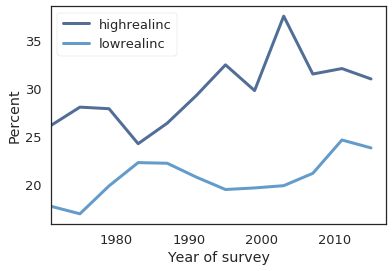

In [81]:
plot_series(grouped_year4, 'highrealinc')
plot_series(grouped_year4, 'lowrealinc')

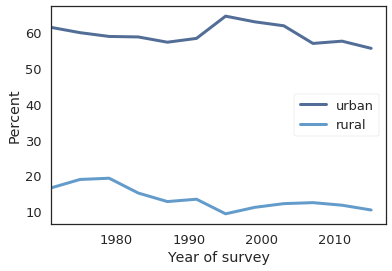

In [82]:
plot_series(grouped_year4, 'urban')
plot_series(grouped_year4, 'rural')

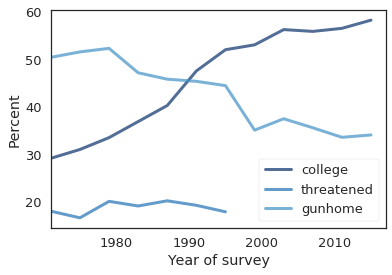

In [83]:
plot_series(grouped_year4, 'college')
plot_series(grouped_year4, 'threatened')
plot_series(grouped_year4, 'gunhome')

### Fill missing values

In [83]:
def fill_missing_column(df, colname):
    """Fills missing values of the given column.

    df: DataFrame
    colname: string
    """
    null = df[df[colname].isnull()]

    print(colname, len(null))

    valid = df[colname].dropna()
    fill = valid.sample(len(null), replace=True)
    fill.index = null.index

    df[colname].fillna(fill, inplace=True)

In [84]:
def fill_age(df):
    """Fills age based on year and cohort.
    
    df: DataFrame
    """
    colname = 'age'
    null = df[df[colname].isnull()]

    print('age', len(null))
    
    fill = df.year - df.cohort

    df[colname].fillna(fill, inplace=True)

In [85]:
def fill_all_missing(df):
    varnames = ['year', 'cohort', 'owngun', 'gun', 'natcrime',
                'income', 'realinc', 'educ', 'polviews',
                'sex', 'race', 'hispanic', 'srcbelt']
    for varname in varnames:
        fill_missing_column(df, varname)
    fill_age(df)

In [86]:
fill_all_missing(sample)

year 0
cohort 190
owngun 24846
gun 43051
natcrime 27880
income 8535
realinc 6864
educ 173
polviews 9270
sex 0
race 0
hispanic 38153
srcbelt 0
age 191


After filling, we have to make booleans again.

In [87]:
make_booleans(sample)

### Center cohort, age, and year.

In [88]:
def center_factors(df):
    """Center factors around their means.
    
    Add centered factors to make the coeffients
    of the model easier to interpret.
    
    df: DataFrame
    """
    df['ones'] = np.ones_like(df.cohort)
    df['c'] = df.cohort - 1966
    df['a'] = df.age - 47
    df['y'] = df.year - 1990
    
    # also add quadratic factors and interaction term
    df['c2'] = df.c**2
    df['a2'] = df.a**2
    df['y2'] = df.y**2
    df['y3'] = df.y**3
    df['ac'] = df.a * df.c

In [89]:
center_factors(sample)

In [92]:
for varname in ['c', 'a', 'y']:
    print(varname, sample[varname].mean())

c -16.592402266833158
a -2.3352383696731023
y 4.0723593634937405


### Run logistic models



Drop records if we don't have the dependent variable.

In [93]:
subset = sample.dropna(subset=['gunlaw'])
subset.shape

(40523, 65)

How many records did we lose?

In [94]:
sample.shape[0] - subset.shape[0]

21943

In [95]:
subset.head()

,year,conrinc,cohort,ballot,wtssall,income,finrela,realinc,sex,homosex,...,highrealinc,ones,c,a,y,c2,a2,y2,y3,ac
0,1972,0.0,1948.0,0,1.7786,12.0,3,31299.0,1,0,...,0.0,1.0,-18.0,-23.0,-18,324.0,529.0,324,-5832,414.0
1,1972,0.0,1938.0,0,0.8893,12.0,3,43994.0,2,0,...,1.0,1.0,-28.0,-13.0,-18,784.0,169.0,324,-5832,364.0
2,1972,0.0,1923.0,0,1.3339,12.0,3,24366.0,1,0,...,0.0,1.0,-43.0,2.0,-18,1849.0,4.0,324,-5832,-86.0
3,1972,0.0,1930.0,0,1.3339,4.0,3,60915.0,1,0,...,1.0,1.0,-36.0,-5.0,-18,1296.0,25.0,324,-5832,180.0
4,1972,0.0,1927.0,0,2.2232,9.0,3,37226.0,1,0,...,0.0,1.0,-39.0,-2.0,-18,1521.0,4.0,324,-5832,78.0


In [96]:
sample.columns

Index(['year', 'conrinc', 'cohort', 'ballot', 'wtssall', 'income', 'finrela',
       'realinc', 'sex', 'homosex', 'hispanic', 'rowngun', 'owngun', 'id_',
       'age', 'race', 'srcbelt', 'polviews', 'natcrime', 'gunlaw', 'gun',
       'gunage', 'gunnum', 'educ', 'cohort5', 'cohort10', 'year4', 'age5',
       'age3', 'twenties', 'thirties', 'forties', 'fifties', 'sixties',
       'seventies', 'eighties', 'nineties', 'favor', 'gunhome', 'threatened',
       'spendcrime', 'topincome', 'lowincome', 'liberal', 'moderate',
       'conservative', 'female', 'ishisp', 'black', 'otherrace', 'urban',
       'suburban', 'rural', 'college', 'lowrealinc', 'highrealinc', 'ones',
       'c', 'a', 'y', 'c2', 'a2', 'y2', 'y3', 'ac'],
      dtype='object')

In [97]:
varnames = ['nineties', 'eighties', 'seventies', 'fifties', 'forties', 'thirties', 'twenties',
            'female', 'black', 'otherrace', 'ishisp', 'conservative', 'liberal', 'lowrealinc', 'highrealinc',
            'college', 'urban', 'rural', 'threatened', 'gunhome']

all_varnames = varnames + ['y', 'y2', 'y3', 'favor']

['nineties',
 'eighties',
 'seventies',
 'fifties',
 'forties',
 'thirties',
 'twenties',
 'female',
 'black',
 'otherrace',
 'ishisp',
 'conservative',
 'liberal',
 'lowrealinc',
 'highrealinc',
 'college',
 'urban',
 'rural',
 'threatened',
 'gunhome',
 'y',
 'y2',
 'y3',
 'favor']

In [98]:
for varname in varnames:
    print(varname, sum(sample[varname].isnull()))

nineties 0
eighties 0
seventies 0
fifties 0
forties 0
thirties 0
twenties 0
female 0
black 0
otherrace 0
ishisp 0
conservative 0
liberal 0
lowrealinc 0
highrealinc 0
college 0
urban 0
rural 0
threatened 0
gunhome 0


Select just the columns we need

In [99]:
data = subset[all_varnames]
data.shape

(40523, 24)

In [101]:
formula = ('favor ~ y + y2 + y3 + nineties + eighties + seventies + fifties + forties + thirties + twenties + '
           'female + black + otherrace + ishisp + conservative + liberal + lowrealinc + highrealinc + ' 
           'college + urban + rural + threatened + gunhome')
model = smf.logit(formula, data=data).fit()

model.summary()

Optimization terminated successfully.
         Current function value: 0.500556
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  favor   No. Observations:                40523
Model:                          Logit   Df Residuals:                    40499
Method:                           MLE   Df Model:                           23
Date:                Tue, 02 Oct 2018   Pseudo R-squ.:                 0.08251
Time:                        12:59:19   Log-Likelihood:                -20284.
converged:                       True   LL-Null:                       -22108.
                                        LLR p-value:                     0.000
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        1.6666      0.047     35.596      0.000       1.575       1.758
y                0.0276      0.002     11.539      0.000       0.023       0.032
y2              -0.0003      0.000     -2.462      0.014      -0.000   -5.34e-05
y3           -6.868e-05   6.87e-06    -10.000      0.000   -8.21e-05   -5.52e-05
nineties        -0.3988      0.107     -3.737      0.000      -0.608      -0.190
eighties        -0.3350      0.066     -5.065      0.000      -0.465      -0.205
seventies       -0.1526      0.053     -2.905      0.004      -0.255      -0.050
fifties         -0.0406      0.037     -1.092      0.275      -0.113       0.032
forties         -0.0530      0.039     -1.360      0.174      -0.129       0.023
thirties        -0.0747      0.043     -1.731      0.084      -0.159       0.010
twenties        -0.0473      0.045     -1.045      0.296      -0.136       0.041
female           0.7144      0.025     28.573      0.000       0.665       0.763
black            0.2332      0.039      6.001      0.000       0.157       0.309
otherrace        0.4540      0.066      6.881      0.000       0.325       0.583
ishisp           0.0160      0.048      0.336      0.737      -0.078       0.110
conservative    -0.3304      0.031    -10.506      0.000      -0.392      -0.269
liberal          0.2443      0.031      7.965      0.000       0.184       0.304
lowrealinc      -0.1420      0.031     -4.554      0.000      -0.203      -0.081
highrealinc      0.0575      0.031      1.862      0.063      -0.003       0.118
college          0.0948      0.027      3.552      0.000       0.042       0.147
urban           -0.2971      0.031     -9.630      0.000      -0.358      -0.237
rural           -0.6029      0.041    -14.714      0.000      -0.683      -0.523
threatened      -0.0874      0.030     -2.885      0.004      -0.147      -0.028
gunhome         -0.8830      0.026    -33.952      0.000      -0.934      -0.832
================================================================================
"""

Make a row for someone in 2016 with all booleans false.

In [102]:
def make_base():
    y = 2016 - 1990
    y2 = y**2
    y3 = y**3

    d = dict(y=y, y2=y2, y3=y3)
    for varname in varnames:
        d[varname] = 0

    return pd.Series(d)

base = make_base()
base

y                  26
y2                676
y3              17576
nineties            0
eighties            0
seventies           0
fifties             0
forties             0
thirties            0
twenties            0
female              0
black               0
otherrace           0
ishisp              0
conservative        0
liberal             0
lowrealinc          0
highrealinc         0
college             0
urban               0
rural               0
threatened          0
gunhome             0
dtype: int64

Make a DataFrame that contains one row for each case we want to consider.

In [103]:
def make_df_pred():
    def add_yminus(df, varname, offset):
        """Add a column with y minus an offset.
        
        df: DataFrame
        varname: string new var name
        offset: how much to shift y
        """
        df.loc[varname] = base
        df.loc[varname, 'y'] += offset
        df.loc[varname, 'y2'] = df.loc[varname, 'y']**2
        df.loc[varname, 'y3'] = df.loc[varname, 'y']**3
    
    base = make_base()
    df_pred = pd.DataFrame(columns=base.index, dtype=float)    
    df_pred.loc['base'] = base

    for varname in varnames:
        df_pred.loc[varname] = base
        df_pred.loc[varname, varname] = 1
    
    add_yminus(df_pred, 'yminus10', -10)
    add_yminus(df_pred, 'yminus20', -20)
    add_yminus(df_pred, 'yminus30', -30)
    add_yminus(df_pred, 'yminus40', -40)
    
    df_pred.loc['lowest combo'] = base
    low_vars = ['gunhome', 'nineties', 'rural', 
                'conservative', 'lowrealinc', 'threatened']
    df_pred.loc['lowest combo', low_vars] = 1
    
    df_pred.loc['highest combo'] = base
    high_vars = ['female', 'otherrace', 'liberal', 
                'college', 'highrealinc']
    df_pred.loc['highest combo', high_vars] = 1
    
    return df_pred
    
df_pred = make_df_pred()

,y,y2,y3,nineties,eighties,seventies,fifties,forties,thirties,twenties,...,ishisp,conservative,liberal,lowrealinc,highrealinc,college,urban,rural,threatened,gunhome
base,26.0,676.0,17576.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
nineties,26.0,676.0,17576.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
eighties,26.0,676.0,17576.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
seventies,26.0,676.0,17576.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
fifties,26.0,676.0,17576.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
forties,26.0,676.0,17576.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
thirties,26.0,676.0,17576.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
twenties,26.0,676.0,17576.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
female,26.0,676.0,17576.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
black,26.0,676.0,17576.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [104]:
pred = model.predict(df_pred) * 100

base             73.110197
nineties         64.597264
eighties         66.043076
seventies        70.007449
fifties          72.304236
forties          72.056059
thirties         71.617267
twenties         72.171137
female           84.743267
black            77.441242
otherrace        81.064225
ishisp           73.424179
conservative     66.145889
liberal          77.635569
lowrealinc       70.228059
highrealinc      74.226121
college          74.932439
urban            66.886987
rural            59.804525
threatened       71.357600
gunhome          52.928399
yminus10         85.319839
yminus20         85.911153
yminus30         82.583214
yminus40         80.491887
lowest combo     19.087668
highest combo    92.859019
dtype: float64

In [105]:
pred - pred['base']

base              0.000000
nineties         -8.512933
eighties         -7.067120
seventies        -3.102748
fifties          -0.805961
forties          -1.054138
thirties         -1.492930
twenties         -0.939060
female           11.633071
black             4.331045
otherrace         7.954028
ishisp            0.313982
conservative     -6.964308
liberal           4.525373
lowrealinc       -2.882137
highrealinc       1.115925
college           1.822243
urban            -6.223210
rural           -13.305671
threatened       -1.752597
gunhome         -20.181797
yminus10         12.209642
yminus20         12.800957
yminus30          9.473017
yminus40          7.381691
lowest combo    -54.022529
highest combo    19.748822
dtype: float64

In [106]:
def make_result(pred):
    """Make a DataFrame with one row per case.
    
    pred: series of predictions
    """
    result = pd.DataFrame()
    result['pred'] = pred
    result['offset'] = pred - pred['base']
    return result

result = make_result(pred)

,pred,offset
base,73.110197,0.000000
nineties,64.597264,-8.512933
eighties,66.043076,-7.067120
seventies,70.007449,-3.102748
fifties,72.304236,-0.805961
forties,72.056059,-1.054138
thirties,71.617267,-1.492930
twenties,72.171137,-0.939060
female,84.743267,11.633071
black,77.441242,4.331045


### Iterate

To estimate uncertainty due to random sampling and missing values, we have to iterate the procedure we just ran.

In [107]:
def run(iters=101):
    """Run the model several times and return a collection of results.
    
    iters: number of times to run
    
    returns: list of DataFrames
    """
    gss = utils.ReadGss('gss_gun')
    replace_invalid(gss)
    
    results = []
    for i in range(iters):
        sample = utils.ResampleByYear(gss).copy()
        fill_all_missing(sample)
        make_booleans(sample)
        center_factors(sample)
        data = sample.dropna(subset=['gunlaw'])
    
        model = smf.logit(formula, data=data).fit()

        df_pred = make_df_pred()
        pred = model.predict(df_pred) * 100
        result = make_result(pred)
        
        results.append(result)
    return results

In [105]:
results = run()

year 0
cohort 208
owngun 24933
gun 43078
natcrime 28046
income 8512
realinc 6897
educ 168
polviews 9373
sex 0
race 0
hispanic 38138
srcbelt 0
age 209
Optimization terminated successfully.
         Current function value: 0.502264
         Iterations 6
year 0
cohort 186
owngun 25039
gun 43179
natcrime 27866
income 8440
realinc 6799
educ 169
polviews 9451
sex 0
race 0
hispanic 38149
srcbelt 0
age 186
Optimization terminated successfully.
         Current function value: 0.502354
         Iterations 6
year 0
cohort 208
owngun 24675
gun 43230
natcrime 28053
income 8569
realinc 6911
educ 159
polviews 9280
sex 0
race 0
hispanic 38146
srcbelt 0
age 208
Optimization terminated successfully.
         Current function value: 0.505096
         Iterations 6
year 0
cohort 197
owngun 24905
gun 43177
natcrime 27804
income 8461
realinc 6801
educ 148
polviews 9307
sex 0
race 0
hispanic 38145
srcbelt 0
age 197
Optimization terminated successfully.
         Current function value: 0.503089
         Itera

Optimization terminated successfully.
         Current function value: 0.505114
         Iterations 6
year 0
cohort 194
owngun 24844
gun 43168
natcrime 28108
income 8461
realinc 6793
educ 164
polviews 9224
sex 0
race 0
hispanic 38147
srcbelt 0
age 195
Optimization terminated successfully.
         Current function value: 0.503110
         Iterations 6
year 0
cohort 185
owngun 25031
gun 43164
natcrime 28002
income 8581
realinc 6912
educ 167
polviews 9422
sex 0
race 0
hispanic 38136
srcbelt 0
age 186
Optimization terminated successfully.
         Current function value: 0.499385
         Iterations 6
year 0
cohort 190
owngun 24983
gun 43129
natcrime 28069
income 8394
realinc 6785
educ 156
polviews 9331
sex 0
race 0
hispanic 38155
srcbelt 0
age 190
Optimization terminated successfully.
         Current function value: 0.502265
         Iterations 6
year 0
cohort 209
owngun 24818
gun 43227
natcrime 27747
income 8354
realinc 6704
educ 167
polviews 9359
sex 0
race 0
hispanic 38154
srcbelt 0


Optimization terminated successfully.
         Current function value: 0.503102
         Iterations 6
year 0
cohort 205
owngun 24763
gun 43129
natcrime 27908
income 8386
realinc 6769
educ 156
polviews 9277
sex 0
race 0
hispanic 38146
srcbelt 0
age 204
Optimization terminated successfully.
         Current function value: 0.504294
         Iterations 6
year 0
cohort 199
owngun 24673
gun 43167
natcrime 27938
income 8607
realinc 6960
educ 164
polviews 9246
sex 0
race 0
hispanic 38161
srcbelt 0
age 198
Optimization terminated successfully.
         Current function value: 0.508624
         Iterations 6
year 0
cohort 182
owngun 24773
gun 43173
natcrime 27908
income 8447
realinc 6789
educ 147
polviews 9301
sex 0
race 0
hispanic 38150
srcbelt 0
age 183
Optimization terminated successfully.
         Current function value: 0.500513
         Iterations 6
year 0
cohort 187
owngun 24612
gun 43227
natcrime 27988
income 8424
realinc 6781
educ 152
polviews 9250
sex 0
race 0
hispanic 38146
srcbelt 0


gun 43167
natcrime 27871
income 8489
realinc 6818
educ 184
polviews 9322
sex 0
race 0
hispanic 38150
srcbelt 0
age 187
Optimization terminated successfully.
         Current function value: 0.504429
         Iterations 6
year 0
cohort 210
owngun 24850
gun 43085
natcrime 27926
income 8507
realinc 6879
educ 161
polviews 9257
sex 0
race 0
hispanic 38159
srcbelt 0
age 211
Optimization terminated successfully.
         Current function value: 0.505179
         Iterations 6
year 0
cohort 177
owngun 24793
gun 43039
natcrime 27770
income 8585
realinc 6946
educ 170
polviews 9293
sex 0
race 0
hispanic 38150
srcbelt 0
age 177
Optimization terminated successfully.
         Current function value: 0.504535
         Iterations 6


Process the results.

In [106]:
preds = [result.pred for result in results]
median, low, high = thinkstats2.PercentileRows(preds, [50, 5, 95])

estimates = pd.DataFrame(index=result.index)
estimates['low5'] = low
estimates['median'] = median
estimates['high95'] = high
estimates.round(1)

,low2.5,median,high97.5
base,72.2,73.5,75.3
nineties,60.1,64.2,68.0
eighties,64.8,67.8,70.4
seventies,67.9,70.1,72.1
fifties,71.3,73.0,74.8
forties,71.7,73.7,75.4
thirties,70.2,72.2,74.1
twenties,71.3,73.2,74.9
female,83.7,84.7,85.8
black,76.3,78.1,80.0


In [107]:
# generate an HTML table

lines = estimates.round(1).to_html().split('\n')
for line in lines:
    print(line)

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>low2.5</th>
      <th>median</th>
      <th>high97.5</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>base</th>
      <td>72.2</td>
      <td>73.5</td>
      <td>75.3</td>
    </tr>
    <tr>
      <th>nineties</th>
      <td>60.1</td>
      <td>64.2</td>
      <td>68.0</td>
    </tr>
    <tr>
      <th>eighties</th>
      <td>64.8</td>
      <td>67.8</td>
      <td>70.4</td>
    </tr>
    <tr>
      <th>seventies</th>
      <td>67.9</td>
      <td>70.1</td>
      <td>72.1</td>
    </tr>
    <tr>
      <th>fifties</th>
      <td>71.3</td>
      <td>73.0</td>
      <td>74.8</td>
    </tr>
    <tr>
      <th>forties</th>
      <td>71.7</td>
      <td>73.7</td>
      <td>75.4</td>
    </tr>
    <tr>
      <th>thirties</th>
      <td>70.2</td>
      <td>72.2</td>
      <td>74.1</td>
    </tr>
    <tr>
      <th>twenties</th>
      <td>71.3</td>
      <td>73.2</td>
      <td>74.

Generate the table for the offsets.

In [108]:
preds = [result.offset for result in results]
median, low, high = thinkstats2.PercentileRows(preds, [50, 2.5, 97.5])

offsets = pd.DataFrame(index=result.index)
offsets['low2.5'] = low
offsets['median'] = median
offsets['high97.5'] = high
offsets.sort_values('median').round(1)

,low2.5,median,high97.5
lowest combo,-58.6,-54.4,-50.4
gunhome,-21.2,-19.9,-18.7
rural,-13.8,-11.4,-9.7
nineties,-14.8,-9.5,-5.3
conservative,-8.9,-7.6,-6.3
eighties,-8.7,-5.9,-2.8
urban,-6.8,-5.3,-4.1
seventies,-5.3,-3.7,-1.2
lowrealinc,-3.7,-2.5,-1.4
threatened,-3.6,-2.3,-1.2


In [109]:
lines = offsets.sort_values('median').round(1).to_html().split('\n')
for line in lines:
    print(line)

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>low2.5</th>
      <th>median</th>
      <th>high97.5</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>lowest combo</th>
      <td>-58.6</td>
      <td>-54.4</td>
      <td>-50.4</td>
    </tr>
    <tr>
      <th>gunhome</th>
      <td>-21.2</td>
      <td>-19.9</td>
      <td>-18.7</td>
    </tr>
    <tr>
      <th>rural</th>
      <td>-13.8</td>
      <td>-11.4</td>
      <td>-9.7</td>
    </tr>
    <tr>
      <th>nineties</th>
      <td>-14.8</td>
      <td>-9.5</td>
      <td>-5.3</td>
    </tr>
    <tr>
      <th>conservative</th>
      <td>-8.9</td>
      <td>-7.6</td>
      <td>-6.3</td>
    </tr>
    <tr>
      <th>eighties</th>
      <td>-8.7</td>
      <td>-5.9</td>
      <td>-2.8</td>
    </tr>
    <tr>
      <th>urban</th>
      <td>-6.8</td>
      <td>-5.3</td>
      <td>-4.1</td>
    </tr>
    <tr>
      <th>seventies</th>
      <td>-5.3</td>
      <td>-3.7</t

### Retrodict trends

How much of the variation over the last 50 years does this model capture?

In [109]:
def predict_favor(df, model):
    """Predict the percentage of people who would favor struct gun laws.
    
    df: DataFrame
    model: model
    
    return: percentage
    """
    probs = model.predict(df)
    bools = np.random.random(len(probs)) < probs
    assert numnull(bools) == 0
    return bools.dropna().mean() * 100

In [110]:
subset.favor.mean(), predict_favor(data, model)

(0.7647262048713076, 76.43313673716162)

In [111]:
sample.favor.mean(), predict_favor(sample, model)

(0.7647262048713076, 76.97147248102968)

In [113]:
grouped_year4 = sample.groupby('year')

In [114]:
for name, group in grouped_year4:
    retro = predict_favor(group, model)
    actual = group.favor.mean() * 100
    print(name, len(group), actual, retro)

1972 1613 69.03846153846153 73.71357718536888
1973 1504 74.84704282800816 74.40159574468085
1974 1484 76.06019151846786 71.7654986522911
1975 1490 73.23162274618585 74.16107382550335
1976 1499 73.08992562542258 72.24816544362909
1977 1530 73.8 70.84967320261438
1978 1532 nan 72.78067885117493
1980 1468 69.51724137931035 68.25613079019074
1982 1860 73.88429752066116 73.27956989247312
1983 1599 nan 75.23452157598499
1984 1473 72.92393579902303 76.44263408010862
1985 1534 72.20026350461133 73.79400260756192
1986 1470 nan 75.64625850340137
1987 1819 72.54791431792559 77.29521715228147
1988 1481 75.3910323253389 75.75962187711006
1989 1537 80.11695906432749 75.73194534808067
1990 1372 80.87739032620922 77.91545189504373
1991 1517 80.63492063492063 79.30125247198417
1993 1606 83.48968105065666 80.19925280199253
1994 2992 77.09072478459198 79.5120320855615
1996 2904 82.38120662039509 80.3030303030303
1998 2832 83.94199785177229 81.14406779661016
2000 2817 80.58409951325041 81.5051473198438
20

In [115]:
def make_result(sample, model):
    actual = pd.Series([])
    retro = pd.Series([])
    grouped_year4 = sample.groupby('year')
    for name, group in grouped_year4:
        retro[name] = predict_favor(group, model)
        actual[name] = group.favor.mean() * 100

    result = pd.DataFrame()
    result['actual'] = actual
    result['retro'] = retro
    result['residual'] = retro - actual
    
    return result

In [116]:
def plot_series(series, **options):
    """Plots Series objects.
    
    series: Series
    """
    thinkplot.plot(series.dropna(), **options)

In [117]:
result = make_result(sample, model)

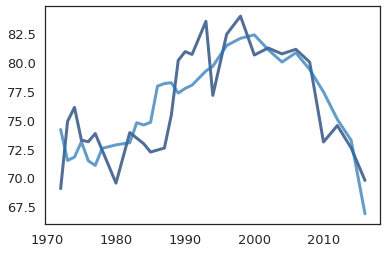

In [118]:
plot_series(result.actual)
plot_series(result.retro)

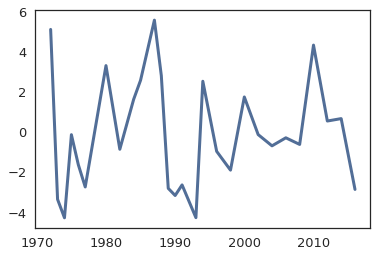

In [119]:
plot_series(result.residual)

In [120]:
def run(formula, iters=201):
    gss = utils.ReadGss('gss_gun')
    replace_invalid(gss)
    
    results = []
    for i in range(iters):
        sample = utils.ResampleByYear(gss).copy()
        fill_all_missing(sample)
        make_booleans(sample)
        center_factors(sample)
        data = sample.dropna(subset=['gunlaw'])
    
        model = smf.logit(formula, data=data).fit()

        result = make_result(sample, model)
        
        results.append(result)
    return results

In [121]:
formula = ('favor ~ y + y2 + y3 + nineties + eighties + seventies + fifties + forties + thirties + twenties + '
           'female + black + otherrace + ishisp + conservative + liberal + lowrealinc + highrealinc + ' 
           'college + urban + rural + threatened + gunhome')
#formula = ('favor ~ y + y2 + y3')
results = run(formula)

year 0
cohort 221
owngun 24800
gun 43186
natcrime 28081
income 8526
realinc 6856
educ 155
polviews 9341
sex 0
race 0
hispanic 38144
srcbelt 0
age 221
Optimization terminated successfully.
         Current function value: 0.506873
         Iterations 6
year 0
cohort 193
owngun 24735
gun 43161
natcrime 27731
income 8480
realinc 6824
educ 162
polviews 9198
sex 0
race 0
hispanic 38149
srcbelt 0
age 192
Optimization terminated successfully.
         Current function value: 0.506572
         Iterations 6
year 0
cohort 178
owngun 24869
gun 43172
natcrime 27852
income 8550
realinc 6917
educ 171
polviews 9326
sex 0
race 0
hispanic 38157
srcbelt 0
age 178
Optimization terminated successfully.
         Current function value: 0.501323
         Iterations 6
year 0
cohort 200
owngun 24790
gun 43164
natcrime 28115
income 8465
realinc 6838
educ 143
polviews 9328
sex 0
race 0
hispanic 38160
srcbelt 0
age 199
Optimization terminated successfully.
         Current function value: 0.502323
         Itera

Optimization terminated successfully.
         Current function value: 0.503489
         Iterations 6
year 0
cohort 173
owngun 24781
gun 43172
natcrime 27987
income 8550
realinc 6906
educ 176
polviews 9253
sex 0
race 0
hispanic 38149
srcbelt 0
age 174
Optimization terminated successfully.
         Current function value: 0.500896
         Iterations 6
year 0
cohort 200
owngun 24793
gun 43125
natcrime 27892
income 8644
realinc 6986
educ 169
polviews 9352
sex 0
race 0
hispanic 38155
srcbelt 0
age 200
Optimization terminated successfully.
         Current function value: 0.505428
         Iterations 6
year 0
cohort 183
owngun 24840
gun 43104
natcrime 27921
income 8648
realinc 6986
educ 173
polviews 9462
sex 0
race 0
hispanic 38151
srcbelt 0
age 183
Optimization terminated successfully.
         Current function value: 0.499190
         Iterations 6
year 0
cohort 151
owngun 24873
gun 43093
natcrime 27914
income 8556
realinc 6884
educ 167
polviews 9263
sex 0
race 0
hispanic 38157
srcbelt 0


Optimization terminated successfully.
         Current function value: 0.503031
         Iterations 6
year 0
cohort 197
owngun 24859
gun 43179
natcrime 27889
income 8506
realinc 6874
educ 178
polviews 9368
sex 0
race 0
hispanic 38140
srcbelt 0
age 198
Optimization terminated successfully.
         Current function value: 0.505958
         Iterations 6
year 0
cohort 228
owngun 24946
gun 43177
natcrime 28052
income 8475
realinc 6827
educ 171
polviews 9288
sex 0
race 0
hispanic 38151
srcbelt 0
age 224
Optimization terminated successfully.
         Current function value: 0.504978
         Iterations 6
year 0
cohort 186
owngun 24862
gun 43174
natcrime 28086
income 8502
realinc 6868
educ 140
polviews 9269
sex 0
race 0
hispanic 38145
srcbelt 0
age 187
Optimization terminated successfully.
         Current function value: 0.504814
         Iterations 6
year 0
cohort 182
owngun 24782
gun 43178
natcrime 28033
income 8445
realinc 6824
educ 154
polviews 9223
sex 0
race 0
hispanic 38150
srcbelt 0


Optimization terminated successfully.
         Current function value: 0.498554
         Iterations 6
year 0
cohort 195
owngun 24832
gun 43073
natcrime 28060
income 8617
realinc 6994
educ 161
polviews 9347
sex 0
race 0
hispanic 38153
srcbelt 0
age 195
Optimization terminated successfully.
         Current function value: 0.506312
         Iterations 6
year 0
cohort 198
owngun 24788
gun 43106
natcrime 27919
income 8429
realinc 6785
educ 153
polviews 9242
sex 0
race 0
hispanic 38151
srcbelt 0
age 198
Optimization terminated successfully.
         Current function value: 0.505228
         Iterations 6
year 0
cohort 188
owngun 24879
gun 43188
natcrime 28086
income 8534
realinc 6889
educ 180
polviews 9205
sex 0
race 0
hispanic 38149
srcbelt 0
age 188
Optimization terminated successfully.
         Current function value: 0.503142
         Iterations 6
year 0
cohort 200
owngun 24838
gun 43223
natcrime 28116
income 8483
realinc 6867
educ 151
polviews 9262
sex 0
race 0
hispanic 38147
srcbelt 0


Optimization terminated successfully.
         Current function value: 0.499060
         Iterations 6
year 0
cohort 190
owngun 24762
gun 43169
natcrime 28129
income 8528
realinc 6896
educ 164
polviews 9295
sex 0
race 0
hispanic 38161
srcbelt 0
age 191
Optimization terminated successfully.
         Current function value: 0.501556
         Iterations 6
year 0
cohort 195
owngun 24712
gun 43167
natcrime 27968
income 8345
realinc 6736
educ 137
polviews 9272
sex 0
race 0
hispanic 38140
srcbelt 0
age 196
Optimization terminated successfully.
         Current function value: 0.500877
         Iterations 6
year 0
cohort 178
owngun 24802
gun 43119
natcrime 28313
income 8500
realinc 6890
educ 154
polviews 9308
sex 0
race 0
hispanic 38146
srcbelt 0
age 178
Optimization terminated successfully.
         Current function value: 0.500760
         Iterations 6
year 0
cohort 209
owngun 24790
gun 43179
natcrime 27989
income 8622
realinc 6977
educ 196
polviews 9412
sex 0
race 0
hispanic 38149
srcbelt 0


Optimization terminated successfully.
         Current function value: 0.503450
         Iterations 6
year 0
cohort 152
owngun 25042
gun 43139
natcrime 27887
income 8477
realinc 6864
educ 168
polviews 9373
sex 0
race 0
hispanic 38157
srcbelt 0
age 152
Optimization terminated successfully.
         Current function value: 0.506210
         Iterations 6
year 0
cohort 204
owngun 24890
gun 43176
natcrime 27888
income 8434
realinc 6793
educ 157
polviews 9195
sex 0
race 0
hispanic 38163
srcbelt 0
age 204
Optimization terminated successfully.
         Current function value: 0.499831
         Iterations 6
year 0
cohort 193
owngun 24862
gun 43135
natcrime 28017
income 8577
realinc 6920
educ 185
polviews 9262
sex 0
race 0
hispanic 38157
srcbelt 0
age 194
Optimization terminated successfully.
         Current function value: 0.507243
         Iterations 6
year 0
cohort 188
owngun 24925
gun 43143
natcrime 27675
income 8425
realinc 6758
educ 148
polviews 9230
sex 0
race 0
hispanic 38152
srcbelt 0


Optimization terminated successfully.
         Current function value: 0.504036
         Iterations 6
year 0
cohort 189
owngun 25034
gun 43123
natcrime 28021
income 8599
realinc 6967
educ 167
polviews 9287
sex 0
race 0
hispanic 38157
srcbelt 0
age 189
Optimization terminated successfully.
         Current function value: 0.499432
         Iterations 6
year 0
cohort 200
owngun 24655
gun 43198
natcrime 27904
income 8528
realinc 6907
educ 137
polviews 9294
sex 0
race 0
hispanic 38154
srcbelt 0
age 199
Optimization terminated successfully.
         Current function value: 0.506776
         Iterations 6
year 0
cohort 188
owngun 24961
gun 43204
natcrime 28129
income 8527
realinc 6894
educ 152
polviews 9362
sex 0
race 0
hispanic 38151
srcbelt 0
age 189
Optimization terminated successfully.
         Current function value: 0.499950
         Iterations 6


In [122]:
def percentile_rows(series_seq, ps):
    """Computes percentiles from aligned series.
    
    series_seq: list of sequences
    ps: cumulative probabilities
    
    returns: Series of x-values, NumPy array with selected rows
    """
    df = pd.concat(series_seq, axis=1).dropna()
    xs = df.index
    array = df.values.transpose()
    array = np.sort(array, axis=0)
    nrows, ncols = array.shape
    indices = (ps * nrows).astype(int)
    rows = array[indices]
    return xs, rows

In [123]:
def get_percentiles(results, varname, ps=None):
    if ps is None:
        ps = [0.05, 0.5, 0.95]
    ps = np.asarray(ps)
    series_seq = [result[varname] for result in results]
    xs, rows = percentile_rows(series_seq, ps)
    return xs, rows

In [124]:
def plot_percentiles(results, varname, color, label, plot=True, fill=True, alpha=0.2):
    """Plots 90% CI and median.
    
    results: list of DataFrames
    varname: string variable names
    color: string color
    label: string label
    plot: boolean, whether to plot the median
    fill: boolean, whether to plot the CI
    """
    xs, rows = get_percentiles(results, varname)
    if fill:
        thinkplot.fill_between(xs, rows[0], rows[2], color=color, alpha=alpha)
    if plot:
        thinkplot.plot(xs, rows[1], color=color, label=label)

Writing gss_gun1.pdf
Writing gss_gun1.png


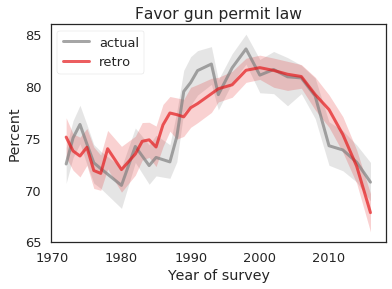

In [146]:
plot_percentiles(results, 'actual', 'gray', 'actual')
plot_percentiles(results, 'retro', RED, 'retro')

thinkplot.config(xlabel='Year of survey', ylabel='Percent',
                title='Favor gun permit law', loc='upper left')

thinkplot.save('gss_gun1', clf=False)

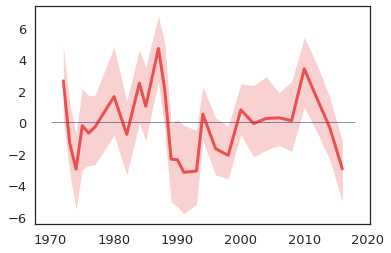

In [126]:
thinkplot.axhline(0)
plot_percentiles(results, 'residual', RED, 'residual')

In [127]:
xs, rows = get_percentiles(results, 'residual')
abs(rows[1]).mean()

1.6350015546126657

In [ ]:
stop

### Test counterfactual code

In [128]:
# may not need this any more, since sample is a copy
counterfact = sample.copy()

In [129]:
def flip(df, varname, val, new_val, prob):
    """Changes the value of a variable for a random sample of rows.
    
    Selects each row where varname==val with probability prob, and
    replaces val with new_val.
    
    df: DataFrame
    varname: string
    val: old value
    new_val: new value
    prob: probability of flipping
    """
    assert(0 < prob < 1)
    #print('flip', val, new_val, prob)
    
    # get indices of the rows that match val
    indices = np.flatnonzero(df[varname] == val)
    #print(len(indices) * prob)
    
    # flip a coin for each selected row
    cond = np.random.random(len(indices)) < prob

    # get indices of the rows that will flip
    flippers = indices[cond]
    #print(len(flippers))
    #print((df.loc[flippers, varname] == val).mean())
    
    # assign the new val to the selected rows
    labels = df.index[flippers]
    df.loc[labels, varname] = new_val

In [130]:
counterfact.college.value_counts()

0.0    33360
1.0    29106
Name: college, dtype: int64

In [131]:
flip(counterfact, 'college', 1, 0, 0.1)

In [132]:
counterfact.college.value_counts()

0.0    36236
1.0    26230
Name: college, dtype: int64

In [133]:
def adjust_prob(df, varname, desired):
    """Flip enough people to make the mean of varname equal desired.

    varname must be a 0,1 boolean

    Can only reliably make small changes.

    df: DataFrame
    varname: string column name
    desired: value between 0 and 1
    """
    actual = df[varname].mean()
    diff = desired - actual
    #print(actual, diff)
    if diff > 0:
        prob = diff / (1-actual)
        flip(df, varname, 0, 1, prob)
    elif diff < 0:
        prob = -diff / actual
        flip(df, varname, 1, 0, prob)

In [134]:
counterfact.college.value_counts()

0.0    36236
1.0    26230
Name: college, dtype: int64

In [135]:
adjust_prob(counterfact, 'college', 0.9)

In [136]:
counterfact.college.value_counts()

1.0    56222
0.0     6244
Name: college, dtype: int64

In [137]:
counterfact.college.mean()

0.9000416226427176

In [138]:
def make_counterfactual(grouped, varname, desired):
    """Modifies a groupby so the proportion of varname is constant.
    
    grouped: groupby object
    varname: string column name
    desired: value to level out at
    """
    for name, group in grouped:
        before = group[varname].mean() * 100
        adjust_prob(group, varname, desired)
        after = group[varname].mean() * 100

        print(name, before, after)

In [139]:
counterfact = sample.copy()

In [140]:
grouped_year4 = counterfact.groupby('year')
grouped_year4.black.mean()

year
1972    0.148791
1973    0.135638
1974    0.101078
1975    0.102013
1976    0.082722
1977    0.120915
1978    0.103133
1980    0.083106
1982    0.280108
1983    0.100063
1984    0.122200
1985    0.101043
1986    0.141497
1987    0.297416
1988    0.118163
1989    0.095641
1990    0.104956
1991    0.156229
1993    0.091532
1994    0.109291
1996    0.133953
1998    0.128531
2000    0.144480
2002    0.132369
2004    0.129801
2006    0.132594
2008    0.133959
2010    0.147260
2012    0.155522
2014    0.134358
2016    0.164283
Name: black, dtype: float64

In [141]:
prob = grouped_year4.black.mean()[1973]
prob

0.1356382978723404

In [142]:
make_counterfactual(grouped_year4, 'black', prob)

/home/downey/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


1972 14.879107253564786 13.32920024798512
1973 13.563829787234042 13.563829787234042
1974 10.107816711590296 13.20754716981132
1975 10.201342281879194 13.95973154362416
1976 8.272181454302869 12.741827885256837
1977 12.091503267973856 13.267973856209151
1978 10.313315926892951 13.381201044386422
1980 8.310626702997276 13.692098092643052
1982 28.01075268817204 14.139784946236558
1983 10.006253908692933 13.50844277673546
1984 12.219959266802444 13.781398506449424
1985 10.104302477183833 13.95045632333768
1986 14.14965986394558 13.60544217687075
1987 29.741616272677295 13.358988455195162
1988 11.816340310600944 13.7744767049291
1989 9.56408588158751 12.491867273910215
1990 10.495626822157435 13.629737609329446
1991 15.622940013183918 13.117996044825315
1993 9.153175591531756 13.636363636363635
1994 10.929144385026738 14.204545454545455
1996 13.395316804407715 13.567493112947659
1998 12.85310734463277 13.52401129943503
2000 14.447994320198793 13.702520411785587
2002 13.236889692585896 13.4

In [143]:
predict_favor(counterfact, model)

76.80498191015913

AttributeError: 'numpy.float64' object has no attribute 'index'

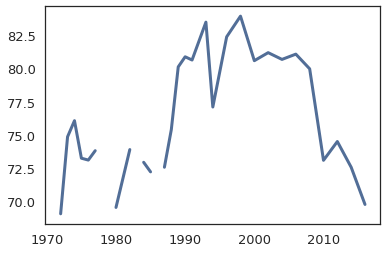

In [144]:
actual = pd.Series([])
counter = pd.Series([])
for name, group in grouped_year4:
    counter[name] = predict_favor(group, model)
    actual[name] = group.favor.mean() * 100

thinkplot.plot(actual.index, actual)
thinkplot.plot(retro.index, retro)
thinkplot.plot(counter.index, counter)

### Run counterfactuals

## Favor gunlaw

In [ ]:
def make_series(grouped, varname):
    """Compute the percentage in each category.
    
    grouped: GroupBy object
    varname: string column name
    
    returns:  Series
    """
    return grouped[varname].mean() * 100

In [ ]:
def plot_gunlaw(grouped):
    """.
    
    grouped:
    """
    varnames = ['favor']
    colors = [BLUE]
    labels = ['Favor']
    series_seq = make_series_seq(grouped, varnames)
    plot_series_seq(series_seq, colors, labels)

Plot the percentage in each religious group as a function of survey year.

In [ ]:
grouped_year = sample.groupby('year')
favor = make_series(grouped_year, 'favor')
favor

In [ ]:
plot_series(favor, color=BLUE, label='favor')
thinkplot.config(xlabel='Year of survey', 
                 ylabel='Percent',
                 xlim=[1971, 2017])

In [ ]:
crime = make_series(grouped_year, 'crime')
crime

In [ ]:
plot_series(crime.loc[1984:], color=RED, label='crime')
thinkplot.config(xlabel='Year of survey', 
                 ylabel='Percent',
                 xlim=[1971, 2017])

In [ ]:
plot_series(favor, color=BLUE, label='favor')
plot_series(crime.loc[1984:], color=RED, label='crime')
thinkplot.config(title='Support for gun control and concern about crime',
                 xlabel='Year of survey', 
                 ylabel='Percent',
                 xlim=[1971, 2017])

In [ ]:
grouped_age = sample.groupby(['age_group'])

In [ ]:
plot_gunlaw(grouped_age)
thinkplot.config(xlabel='Age', ylabel='Percent')

Plot the percentage in favor of gun permits as a function of birth cohort.

In [ ]:
grouped_cohort = sample.groupby(['cohort5'])

In [ ]:
heri = pd.read_csv('heri_gun_control.csv')

In [ ]:
heri.year

In [ ]:
heri = pd.read_csv('heri_gun_control.csv')
thinkplot.plot(heri.year, heri.agree, color=ORANGE)

In [ ]:
plot_gunlaw(grouped_cohort)
thinkplot.plot(heri.yearm18, heri.agree, color=ORANGE, label='CIRP')
thinkplot.config(xlabel='Year of birth', ylabel='Percent')

## Logistic models

In [ ]:
def make_logit_model(df, var, factors):
    """Fit a logistic regression model.
    
    df: DataFrame
    var: string name of dependent variable
    factors: list of string names for factorscen
    
    returns: Logit model
    """
    # TODO: investigate the missing=drop option
    nonull = df.dropna(subset=factors+[var])
    y = nonull[var].values
    X = nonull[factors].values
    return Logit(y, X).fit(disp=False, full_output=False)

In [ ]:
factors = ['ones', 'a', 'c', 'a2', 'c2', 'ac']
factors = ['a', 'a2', 'nineties', 'eighties', 'seventies',
           'sixties', 'fifties', 'forties', 'thirties', 'twenties']
model = make_logit_model(sample, 'favor', factors)

In [ ]:
def predict_logit_model(age, model, year, factors):
    """Make a single-year prediction.
    
    age: Series of ages to simulate
    model: Logit model
    year: year to make a prediction for
    factors: list of string names for factors
    
    returns: Series that maps index to percentage
    """
    # resample the ages
    n = len(age)
    age = np.random.choice(age, n, replace=True)
    
    # compute cohort
    cohort = year - age
    df = pd.DataFrame(dict(cohort=cohort, age=age))
    center_factors(df)
    
    # compute probabilities in each category for each respondent
    X = df[factors].values
    pred = model.predict(X)
    
    # toss a weighted coin for each respondent
    choices = np.random.random(n) <= pred

    # return the percentage in favor
    return choices.mean() * 100

In [ ]:
age = sample.loc[sample.year==2016, 'age']

In [ ]:
predict_logit_model(age, model, 1976, factors)

In [ ]:
predict_logit_model(age, model, 2016, factors)

In [ ]:
predict_logit_model(age, model, 2026, factors)

In [ ]:
predict_logit_model(age, model, 2036, factors)

In [ ]:
def make_pred(df, var, varnames, years, factors):
    """Generate predictions from multinomial model.
    
    df: DataFrame of respondents
    var: dependent variable
    varnames: list of string variable names
    years: sequence of years to generate predictions for
    factors: list of string factor names for the model
    
    returns: DataFrame that maps from index to predicted values
    """ 
    model = make_logit_model(df, var, factors)
    age = df.loc[df.year==2016, 'age']

    pred = pd.DataFrame(columns=varnames)
    for year in years:
        pred.loc[year] = predict_logit_model(age, model, year, factors)
    return pred

In [ ]:
def plot_pred(df, pred, varnames, colors, alpha=0.2):
    """Plots predictions from multinomial model.
    
    pred: DataFrame with one column per variable
    varnames: list of string variable names
    colors: list of string colors
    alpha: numerical transparency
    """
    series_seq = [pred[var] for var in varnames]
    for series, color in zip(series_seq, colors):
        thinkplot.plot(series, color=color, alpha=alpha)
    thinkplot.config(xlabel='Year of survey', loc='upper right')

In [ ]:
var = 'favor'
varnames = ['favor']
years = np.arange(1970, 2038)
factors = ['ones', 'a', 'c']
colors = [BLUE]

pred = make_pred(sample, var, varnames, years, factors)
plot_pred(sample, pred, varnames, colors)
plot_gunlaw(grouped_year)
thinkplot.config(xlim=[1971, 2038])

In [ ]:
var = 'favor'
varnames = ['favor']
years = np.arange(1970, 2038)
factors = ['ones', 'a', 'c', 'a2', 'c2', 'ac']
index = ['favor']
colors = [BLUE]

pred = make_pred(sample, var, varnames, years, factors)
plot_pred(sample, pred, varnames, colors)
plot_gunlaw(grouped_year)
thinkplot.config(xlim=[1971, 2038])

In [ ]:
var = 'favor'
varnames = ['favor']
years = np.arange(1970, 2038)
factors = ['a', 'a2', 'nineties', 'eighties', 'seventies',
           'sixties', 'fifties', 'forties', 'thirties', 'twenties']
index = ['favor']
colors = [BLUE]

pred = make_pred(sample, var, varnames, years, factors)
plot_pred(sample, pred, varnames, colors)
plot_gunlaw(grouped_year)
thinkplot.config(xlim=[1971, 2038])

## Resampling

In [ ]:
def make_series_df(grouped, varnames):
    """Compute the percentage in each category.
    
    grouped: GroupBy object with one-hots for each category
    varnames: list of string column names
    
    returns: DataFrame
    """
    df = pd.DataFrame(columns=varnames)
    for var in varnames:
        df[var] = grouped[var].mean() * 100
    return df

In [ ]:
def plot_percentiles(dfs, varnames, colors, labels, plot=True, fill=True, alpha=0.2):
    """Plots 90% CI and median.
    
    dfs: list of DataFrames
    varnames: list of string variable names
    colors: list of string colors
    labels: list of string labels
    plot: boolean, whether to plot the median
    fill: boolean, whether to plot the CI
    """
    ps = np.array([0.05, 0.5, 0.95])

    for var, color, label in zip(varnames, colors, labels):
        series_seq = [df[var] for df in dfs]
        xs, rows = percentile_rows(series_seq, ps)
        if fill:
            thinkplot.fill_between(xs, rows[0], rows[2], color=color, alpha=alpha)
        if plot:
            thinkplot.plot(xs, rows[1], color=color, label=label)

In [ ]:
def run_data(df, groupvar, varnames, iters=11):
    """Resample and extract data.
    
    df: DataFrame
    groupvar: string variable to group by
    varnames: list of string variable names
    iters: number of resamples
    """
    def run():
        sample = utils.ResampleByYear(df)
        grouped_year = sample.groupby([groupvar])
        return make_series_df(grouped_year, varnames)

    dfs = [run() for _ in range(iters)]
    return dfs

In [ ]:
def run_model(df, var, varnames, years, iters=11):
    """Resample and make predictions.
    
    df: DataFrame
    var: string variable name to model
    varnames: list of string variable names
    years: list of years to predict
    iters: number of resamples
    
    returns: list of DataFrames
    """
    factors = ['ones', 'a', 'c', 'a2', 'c2', 'ac']
    factors = ['a', 'a2', 'nineties', 'eighties', 'seventies',
               'sixties', 'fifties', 'forties', 'thirties', 'twenties']

    def run():
        sample = utils.ResampleByYear(df)
        return make_pred(sample, var, varnames, years, factors)

    dfs = [run() for _ in range(iters)]
    return dfs

## Favor gun permits

In [ ]:
iters = 31

In [ ]:
groupvar = 'year'
varnames = ['favor']

In [ ]:
dfs1 = run_data(gss, groupvar, varnames, iters=iters)

In [ ]:
colors = [BLUE]
labels = [None]
plot_percentiles(dfs1, varnames, colors, labels)
thinkplot.config(title='Favor gun control', 
                 xlabel='Year of survey', ylabel='Percent',
                 xlim=[1971, 2017], ylim=[50, 90])

save_options = dict(fmt='png', dpi=50)
thinkplot.SaveFormat('favor_year', **save_options)

In [ ]:
groupvar = 'cohort5'
dfs2 = run_data(gss, groupvar, varnames, iters=iters)

In [ ]:
plot_percentiles(dfs2, varnames, colors, labels=['GSS'])
thinkplot.config(title='Favor gun control, by year of birth', 
                 xlabel='Year of birth', ylabel='Percent',
                 xlim=[1892, 2000], ylim=[50, 90], loc='lower right')

thinkplot.SaveFormat('favor_age', **save_options)

In [ ]:
plot_percentiles(dfs2, varnames, colors, labels=['GSS'])

# dropping the last data point because its a different question
old = heri[heri.year<2016]
thinkplot.plot(old.yearm18, old.agree, color=ORANGE, label='CIRP')

thinkplot.config(title='Favor gun control, by year of birth', 
                 xlabel='Year of birth', ylabel='Percent',
                 xlim=[1892, 2000], ylim=[50, 90], loc='lower right')

thinkplot.SaveFormat('favor_age_cirp', **save_options)

In [ ]:
var = 'favor'
years = np.arange(1972, 2030)

dfs3 = run_model(gss, var, varnames, years, iters=iters)

In [ ]:
nolabels= [None]
plot_percentiles(dfs3, varnames, colors, nolabels, plot=False)
plot_percentiles(dfs1, varnames, colors, labels, fill=False)
thinkplot.config(title='Favor gun control, predicted', 
                 xlabel='Year of survey', ylabel='Percent',
                 xlim=[1971, 2030], ylim=[50, 90])

thinkplot.SaveFormat('favor_year_pred', **save_options)

## Breakdown by political view

In [ ]:
gss.polviews.value_counts()

In [ ]:
liberal = gss[gss.liberal]
liberal.shape

In [ ]:
conservative = gss[gss.conservative]
conservative.shape

In [ ]:
moderate = gss[gss.moderate]
moderate.shape

In [ ]:
groupvar = 'cohort5'
dfs_lib = run_data(liberal, groupvar, varnames, iters=iters)
dfs_mod = run_data(moderate, groupvar, varnames, iters=iters)
dfs_con = run_data(conservative, groupvar, varnames, iters=iters)

In [ ]:
plot_percentiles(dfs_lib, varnames, [BLUE], labels=['liberal'], alpha=0.1)
plot_percentiles(dfs_mod, varnames, [PURPLE], labels=['moderate'], alpha=0.1)
plot_percentiles(dfs_con, varnames, [RED], labels=['conservative'], alpha=0.1)
thinkplot.config(title='Favor gun control, grouped by political view', 
                 xlabel='Year of birth', ylabel='Percent',
                 xlim=[1892, 2000], ylim=[40, 100], loc='lower left')

thinkplot.SaveFormat('favor_polview_year', **save_options)

In [ ]:
groupvar = 'year'
dfs_lib = run_data(liberal, groupvar, varnames, iters=iters)
dfs_mod = run_data(moderate, groupvar, varnames, iters=iters)
dfs_con = run_data(conservative, groupvar, varnames, iters=iters)

In [ ]:
plot_percentiles(dfs_lib, varnames, [BLUE], labels=['liberal'], alpha=0.1)
plot_percentiles(dfs_mod, varnames, [PURPLE], labels=['moderate'], alpha=0.1)
plot_percentiles(dfs_con, varnames, [RED], labels=['conservative'], alpha=0.1)
thinkplot.config(title='Favor gun control, grouped by political view', 
                 xlabel='Year of survey', ylabel='Percent',
                 xlim=[1972, 2017], ylim=[40, 100], loc='lower left')

thinkplot.SaveFormat('favor_polview_year', **save_options)

## Breakdown by race

In [ ]:
gss.race.value_counts()

In [ ]:
white = gss[gss.race == 1]
white.shape

In [ ]:
black = gss[gss.race == 2]
black.shape

In [ ]:
nonwhite = gss[gss.race.isin([2,3])]
nonwhite.shape

In [ ]:
white.favor.mean(), black.favor.mean(), nonwhite.favor.mean()

In [ ]:
liberal.favor.mean(), moderate.favor.mean(), conservative.favor.mean()

In [ ]:
white.liberal.mean(), black.liberal.mean(), nonwhite.liberal.mean()

In [ ]:
white.threatened.mean(), black.threatened.mean(), nonwhite.threatened.mean()

In [ ]:
gss.groupby('threatened').favor.mean()

In [ ]:
groupvar = 'year'
varnames = ['favor']

In [ ]:
dfs_white = run_data(white, groupvar, varnames, iters=iters)
dfs_nonwhite = run_data(nonwhite, groupvar, varnames, iters=iters)

In [ ]:
plot_percentiles(dfs_white, varnames, [BLUE], labels=['white'], alpha=0.1)
plot_percentiles(dfs_nonwhite, varnames, [ORANGE], labels=['nonwhite'], alpha=0.1)
thinkplot.config(title='Favor gun control, grouped by race', 
                 xlabel='Year of survey', ylabel='Percent',
                 xlim=[1971, 2017], ylim=[40, 100], loc='lower left')

thinkplot.SaveFormat('favor_race_year', **save_options)

In [ ]:
young = gss[gss.age<30]
young_white = young[young.race == 1]
young_nonwhite = young[young.race.isin([2,3])]

groupvar = 'year4'

In [ ]:
dfs_white = run_data(young_white, groupvar, varnames, iters=iters)
dfs_nonwhite = run_data(young_nonwhite, groupvar, varnames, iters=iters)

In [ ]:
plot_percentiles(dfs_white, varnames, [BLUE], labels=['white'], alpha=0.1)
plot_percentiles(dfs_nonwhite, varnames, [ORANGE], labels=['nonwhite'], alpha=0.1)
thinkplot.config(title='Favor gun control, by year of survey', 
                 xlabel='Year of survey', ylabel='Percent',
                 xlim=[1970, 2017], ylim=[40, 100], loc='lower left')

#thinkplot.SaveFormat('permit_cohort_race', **save_options)

In [ ]:
groupvar = 'cohort5'
dfs_white = run_data(white, groupvar, varnames, iters=iters)
dfs_nonwhite = run_data(nonwhite, groupvar, varnames, iters=iters)

In [ ]:
plot_percentiles(dfs_white, varnames, [BLUE], labels=['white'], alpha=0.1)
plot_percentiles(dfs_nonwhite, varnames, [ORANGE], labels=['nonwhite'], alpha=0.1)
thinkplot.config(title='Favor gun control, by year of birth', 
                 xlabel='Year of birth', ylabel='Percent',
                 xlim=[1892, 2000], ylim=[40, 100], loc='lower left')

thinkplot.SaveFormat('permit_cohort_race', **save_options)

## Gun in home

In [ ]:
groupvar = 'year'
varnames = ['gunhome']

In [ ]:
dfs4 = run_data(gss, groupvar, varnames, iters=iters)

In [ ]:
colors = [RED]
labels = [None]
plot_percentiles(dfs4, varnames, colors, labels)
thinkplot.config(title='Have gun in home, by year of survey', 
                 xlabel='Year of survey', ylabel='Percent',
                 xlim=[1970, 2017], ylim=[0, 70])

thinkplot.SaveFormat('gunhome_year', **save_options)

In [ ]:
groupvar = 'cohort5'
dfs5 = run_data(gss, groupvar, varnames, iters=iters)

In [ ]:
plot_percentiles(dfs5, varnames, colors, labels)
thinkplot.config(title='Have gun in home, by year of birth', 
                 xlabel='Year of birth', ylabel='Percent',
                 xlim=[1884, 2000], ylim=[0, 70])

thinkplot.SaveFormat('gunhome_cohort', **save_options)

In [ ]:
var = 'gunhome'
years = np.arange(1972, 2030)

dfs6 = run_model(gss, var, varnames, years, iters=iters)

In [ ]:
nolabels= [None]
plot_percentiles(dfs6, varnames, colors, nolabels, plot=False)
plot_percentiles(dfs4, varnames, colors, labels, fill=False)
thinkplot.config(title='Have gun in home, predicted', 
                 xlabel='Year of survey', ylabel='Percent',
                 xlim=[1970, 2032], ylim=[0, 70])

thinkplot.SaveFormat('gunhome_pred', **save_options)

In [ ]:
heri = pd.read_csv('heri_gun_control.csv')

In [ ]:
heri

In [ ]:
old = heri[heri.year<2016]
new = heri[heri.year>=2016]

In [ ]:
thinkplot.plot(old.year, old.agree, color=ORANGE, label='"Do more to control sale of handguns"')
thinkplot.plot(new.year, new.agree, 's', color=RED, label='"Should have stricter gun control laws"')

thinkplot.config(title='Favor gun control, CIRP Freshman Survey', 
                 xlabel='Year of survey', ylabel='Percent',
                 xlim=[1987, 2018], ylim=[60, 90], loc='lower left')

thinkplot.SaveFormat('control_year_cirp', **save_options)

## Age effect

In [ ]:
sample.head()

In [ ]:
grouped = sample.groupby('cohort10')
for name, group in grouped:
    print(name, len(group))

In [ ]:
cohort = grouped.get_group(1950.0)

In [ ]:
def plot_favor_by_age(cohort, **options):
    age_groups = cohort.groupby('age3')
    series = age_groups.favor.mean() * 100
    thinkplot.plot(series.index, series.values, **options)

In [ ]:
names = [1940.0, 1950.0, 1960.0, 1970.0, 1980.0, 1990.0]
labels = ['40s', '50s', '60s', '70s', '80s', '90s']
colors = [RED, ORANGE, YELLOW, GREEN, BLUE, PURPLE]

for i, name in enumerate(names):
    cohort = grouped.get_group(name)
    plot_favor_by_age(cohort, label=labels[i], color=colors[i])
    
thinkplot.config(title='Favor gun control, grouped by decade of birth', 
                 xlabel='Age', ylabel='Percent',
                 xlim=[15, 80], ylim=[40, 95], loc='lower right')

thinkplot.SaveFormat('favor_birth_age', **save_options)

In [ ]:
def plot_favor_by_year(cohort, **options):
    age_groups = cohort.groupby('year4')
    series = age_groups.favor.mean() * 100
    thinkplot.plot(series.index, series.values, **options)

In [ ]:
for i, name in enumerate(names):
    cohort = grouped.get_group(name)
    plot_favor_by_year(cohort, label=labels[i], color=colors[i])
    
thinkplot.config(title='Favor gun control, grouped by decade of birth', 
                 xlabel='Year of survey', ylabel='Percent',
                 xlim=[1970, 2019], ylim=[40, 95], loc='lower left')

thinkplot.SaveFormat('favor_birth_year', **save_options)

In [ ]:
formula = 'favor ~ a + a2 + c + c2 + C(cohort10)'
formula = 'favor ~ a + a2 + c + c2'
formula = 'favor ~ a + nineties + eighties + seventies + sixties + fifties + forties + thirties + twenties'

model = smf.logit(formula, data=sample).fit()
model.summary()

In [ ]:
def predict_favor_by_age(model, birth_year):
    age = np.linspace(20, 65)
    cohort = np.ones_like(age) * birth_year
    new = pd.DataFrame(dict(age=age, cohort=cohort))
    center_factors(new)
    predicted = model_predict(model, new)
    return predicted

In [ ]:
def plot_predicted_by_age(predicted, **options):
    thinkplot.plot(predicted.age, predicted.pred, **options)

In [ ]:
name = 1950.0
predicted = predict_favor_by_age(model, name)
plot_predicted_by_age(predicted, color=RED, linewidth=20, alpha=0.1)

cohort = grouped.get_group(name)
plot_favor_by_age(cohort, label='50s', color=RED)

In [ ]:
for i, name in enumerate(names):
    predicted = predict_favor_by_age(model, name)
    plot_predicted_by_age(predicted, color=colors[i], linewidth=5, alpha=0.2)
    cohort = grouped.get_group(name)
    plot_favor_by_age(cohort, label=labels[i], color=colors[i])
    
thinkplot.config(title='Favor gun control, by age', 
                 xlabel='Age', ylabel='Percent',
                 xlim=[15, 70], ylim=[40, 95], loc='lower right')

In [ ]:
var = 'favor'
years = np.arange(1972, 2030)

dfs3 = run_model(gss, var, varnames, years, iters=iters)

In [ ]:
nolabels= [None]
plot_percentiles(dfs3, varnames, colors, nolabels, plot=False)
plot_percentiles(dfs1, varnames, colors, labels, fill=False)
thinkplot.config(title='Favor gun control, predicted', 
                 xlabel='Year of survey', ylabel='Percent',
                 xlim=[1971, 2030], ylim=[50, 90])

thinkplot.SaveFormat('permit_pred', **save_options)